In [ ]:
import urllib2
import sqlite3
import numpy as np
import pandas as pd
from sys import stdout
from datetime import datetime
import json

# Step 1: Select tweets sent from Foursquare app

In [ ]:
#Step 1: Select tweets sent from Foursquare app
foursquaredata = 0
useWholeDB = True
if useWholeDB:
    con = sqlite3.connect('data/allSpringTweets.db')
    foursquaredata = pd.read_sql("SELECT * from tweets WHERE source = 'Foursquare'", con)
else:
    con = sqlite3.connect('data/foursquareSpring.db')
    foursquaredata = pd.read_sql("SELECT * from tweets", con)

In [82]:
print 'Total tweets from 4sq:', len(foursquaredata)

Total tweets from 4sq: 92387


# Step 2: Extract scipt data that contains JSON from link in the tweets

In [87]:
from bs4 import BeautifulSoup
def extract_urls(lst):
        urls = []
        for j in lst.split(' '):
            if j.startswith('http'):
                urls.append(j)
        return urls

def resolve_url(starturl):
    try:
        req = urllib2.Request(starturl)
        res = urllib2.urlopen(req, timeout = 2)
        finalurl = res.geturl()
        soup = BeautifulSoup(res.read())
        #print soup.find_all('script')
        #print(soup.prettify())
        
        return soup
    except:
        pass
    
def progress(i, n):
    stdout.write("\r%f%%" % (i*100/float(n)))
    stdout.flush()
    if i == n-1:
        stdout.write("\r100%")
        print("\r\n")

In [ ]:
#Step 2: Extract scipt data that contains JSON from link in the tweets
batchSize = len(foursquaredata)/10
for iteration in range(1,11):
    print iteration
    print '\n'
    htmls = []
    for index, row in foursquaredata[iteration*batchSize:(iteration+1)*batchSize].iterrows():
        lst = row.content
        urls = extract_urls(lst)
        #Get the url content
        if len(urls):
            htmls.append(resolve_url(urls[0]))
        progress(index-iteration*batchSize,batchSize)
    
    #Get the string with javascript and it's JSON
    scripts = []
    for html in htmls:
        if (html is not None):
            if len(html.find_all('script'))>10:
                scripts.append([str(html.find_all('script')[10])])
            else:
                scripts.append([])
        else:
            scripts.append([])
     
    with open('data/script'+str(iteration+1)+'.p', 'wb') as fileToSave:
        np.save(fileToSave, scripts)

In [ ]:
#You can load all the saved scripts
with open('data/allScripts.p') as fileWithScripts:
    theScripts = np.load(fileWithScripts)

In [89]:
totalExtracted = 0
for scriptArray in theScripts:
    if len(scriptArray):
        totalExtracted = totalExtracted + 1
print 'Total scripts from 4sq:', totalExtracted

Total scripts from 4sq: 87253


In [6]:
#Join all the scripts 
for iteration in range(1,9):
    with open('data/script'+str(iteration)+'.p', 'r') as fileToSave:
        theScripts = np.append(theScripts, np.load(fileToSave))

# Step 3: Get JSON out of scripts string

In [12]:
#Step 3: Get JSON out of scripts string
checkinStopWord = 'checkin: '
venueStopWord = ',venue: ' 
failed = 0
parsedCheckins = []
for scriptArray in theScripts:
    if len(scriptArray):
        scriptString = scriptArray[0]
        checkInJSON = scriptString[scriptString.find(checkinStopWord)+len(checkinStopWord):scriptString.find(venueStopWord)]
        try:
            parsedCheckins.append(json.loads(checkInJSON))
        except:
            failed = failed + 1
print 'Failed to parse:', failed

204


# Step 4: Save it all to big JSON array

In [ ]:
with open('data/checkins.json', 'w') as outfile:
    json.dump(parsedCheckins, outfile)

In [4]:
with open('data/allSpringCheckins.json', 'r') as datafile:
      parsedCheckins = json.load(datafile)
print len(parsedCheckins)

87049


# Step 5: Get Data Frame out of JSON

In [96]:
#Create Categories data frame
categories = []
categoryIds = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    for category in checkInVenue['categories']:
        if category['primary']:
            if category['id'] not in categoryIds:
                categories.append({'categoryId':category['id'],
                                  'name':category['name']})
                categoryIds.append(category['id'])
                
categoriesDF = pd.DataFrame(categories)

In [97]:
#Create Venues data frame
venues = []
venuesIds = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    if checkInVenue['id'] not in venuesIds:
        venueInfo = {'venueId':checkInVenue['id'],
                    'name':checkInVenue['name'],
                    'checkinsCount':checkInVenue['stats']['checkinsCount'],
                    'tipCount':checkInVenue['stats']['tipCount'],
                    'usersCount':checkInVenue['stats']['usersCount']}
        for category in checkInVenue['categories']:
            if category['primary']:
                venueInfo["categoryId"] = category['id']
        if checkInVenue['location']:
            if 'address' in checkInVenue['location'].keys() and checkInVenue['location']['address']:
                venueInfo["address"] = checkInVenue['location']['address']
        if 'postalCode' in checkInVenue.keys() and checkInVenue['postalCode']:
            venueInfo["categoryId"] = checkInVenue['postalCode']
        if 'neighborhood' in checkInVenue.keys() and checkInVenue['neighborhood']:
            venueInfo["neighborhood"] = checkInVenue['neighborhood']
        if 'lat' in checkInVenue.keys() and 'lng' in checkInVenue.keys() and checkInVenue['lat'] and checkInVenue['lng']:
            venueInfo["lat"] = checkInVenue['lat']
            venueInfo["lng"] = checkInVenue['lng']
        venues.append(venueInfo)
        venuesIds.append(checkInVenue['id'])
                
venuesDF = pd.DataFrame(venues)

In [98]:
#Create Users data frame
users = []
userIds = []
for checkIn in parsedCheckins:
    userInVenue = checkIn['user']
    if userInVenue['id'] not in userIds:
        userInfo = {'userId':userInVenue['id'],
                    'checkinsCount':0}
        if 'gender' in userInVenue.keys() and userInVenue['gender']:
            userInfo["gender"] = userInVenue['gender']
        if 'firstName' in userInVenue.keys() and userInVenue['firstName']:
            userInfo["firstName"] = userInVenue['firstName']
        if 'lastName' in userInVenue.keys() and userInVenue['lastName']:
            userInfo["lastName"] = userInVenue['lastName']
        users.append(userInfo)
        userIds.append(userInVenue['id'])
                
usersDF = pd.DataFrame(users)

In [99]:
#Create Check-ins data frame
checkIns = []
checinIds = []
for checkIn in parsedCheckins:
    if checkIn['id'] not in checinIds:
        checkInInfo = {'checinId':checkIn['id'],
                    'createdAt':checkIn['createdAt'],
                    'tzOffset':checkIn['timeZoneOffset'],
                    'userId':checkIn['user']['id'],
                    'venueId':checkIn['venue']['id']}
        
        if 'likes' in checkIn.keys() and checkIn['likes']:
            userInfo["likes"] = checkIn['likes']['count']
        if 'photos' in checkIn.keys() and checkIn['photos']:
            userInfo["photos"] = checkIn['photos']['count']
        checkIns.append(checkInInfo)
        checinIds.append(checkIn['id'])
                
checkinsDF = pd.DataFrame(checkIns)

In [67]:
# A try on generic parser
def getDataFrameFromCheckinsJSON(keysMapping, optionalKeysMapping, parsedCheckins, subPath = False):
    items = []
    itemIds = []
    for checkIn in parsedCheckins:
        
        if subPath:
            itemData = checkIn[subPath]
        else:
            itemData = checkIn

        if itemData['id'] not in itemIds:
            itemInfo = {}
            
            #Add all requires values
            for keysMap in keysMapping:
                if keysMap['jsonKey'] is str:
                    itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonkey']]
                else:
                    itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonKey']['key']][keysMap['jsonKey']['subKey']]
            
            #Add all optional values
            for key in optionalKeysMapping:
                if keysMap['jsonKey'] is str:
                    if keysMap['jsonkey'] in itemData.keys():
                        itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonkey']]
                else:
                    if keysMap['jsonKey']['key'] in itemData.keys() and keysMap['jsonKey']['subKey'] in itemData[keysMap['jsonKey']['key']].keys():
                        itemInfo[keysMap['pandasKey']] = itemData[keysMap['jsonKey']['key']][keysMap['jsonKey']['subKey']]

            users.append(itemInfo)
            itemIds.append(itemData['id'])

    itemsDF = pd.DataFrame(items)

# Step 4: Saving all data from JSON to SQLLite with tables: Users, Venues, Checkins, Categories

In [100]:
#Saving all data from JSON to SQLLite
checkinCon = sqlite3.connect('data/checkins.db')

In [104]:
checkinsDF.to_sql('checkins', checkinCon)

In [103]:
categoriesDF.to_sql('categories', checkinCon)

In [102]:
venuesDF.to_sql('venues', checkinCon)

In [101]:
usersDF.to_sql('users', checkinCon)

# Analyze!

In [ ]:
venuesDF[venuesDF['categoryId'].isin(healthIds)].sort('checkinsCount',ascending = False)

In [224]:
categories = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    for category in checkInVenue['categories']:
        if category['primary']:
            categories.append({'id':category['id'],
                              'name':category['name']})
catDF = pd.DataFrame(categories)

In [225]:
healthCheckins = []
for checkIn in parsedCheckins:
    checkInVenue = checkIn['venue']
    for category in checkInVenue['categories']:
        if category['id'] in healthIds:
            healthCheckins.append(checkIn)
            break

In [226]:
healthUsers = []
for checkIn in healthCheckins:
    checkInUser = checkIn['user']
    healthUsers.append({'id':checkInUser['id']})
healthUserDF = pd.DataFrame(healthUsers)

In [227]:
venues = []
for checkIn in healthCheckins:
    checkInVenue = checkIn['venue']
    venues.append({'id':checkInVenue['id'],
                              'name':checkInVenue['name'],
                              'usersCount':checkInVenue['stats']['usersCount']})
healthVenuesDF = pd.DataFrame(venues)

In [228]:
healthUsersTotal = []
for checkIn in healthCheckins:
    checkInUser = checkIn['user']
    if checkInUser['id'] in healthUsersIds:
        healthUsersTotal.append({'id':checkInUser['id']})
healthUserTotalDF = pd.DataFrame(healthUsersTotal)

In [243]:
groupedCat = catDF.groupby(['name'])['id'].agg('count').order(ascending=False)

In [230]:
groupedUsersHealth = healthUserDF.groupby(['id'])['id'].agg('count').order(ascending=False)

In [231]:
groupedUsersHealthTotal = healthUserTotalDF.groupby(['id'])['id'].agg('count').order(ascending=False)

In [232]:
groupedUsers = userDF.groupby(['id'])['id'].agg('count').order(ascending=False)

In [250]:
groupedVenues = healthVenuesDF.groupby(['id'])['id'].agg('count').order(ascending=False)

In [251]:
groupedVenues[0:10]

id
4bdd5f27f219c9b6bb751210    384
4e4aab0f62e13240b700e034    167
4bc090ca920eb7132e14192c     84
4bc8760792b376b03767513a     73
4b9bb751f964a520361d36e3     70
4bdc9716afe8c9b689235085     61
4bb41c28f187a593f1e913f8     51
4cee97333b03f04da5ba3adc     39
4c11f318d5599521185818b9     34
4b827a36f964a52098d430e3     31
Name: id, dtype: int64

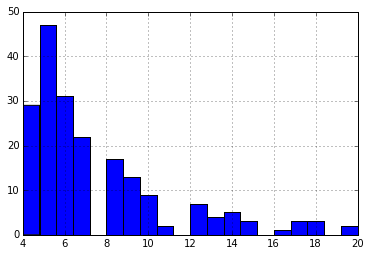

In [235]:
%matplotlib inline 
groupedUsersHealthTotal[2:200].hist(bins = 20)

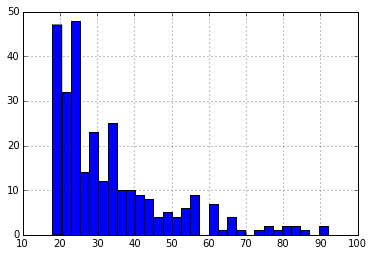

In [240]:
#Per user
groupedUsers[10:300].hist(bins = 30)

In [249]:
len(catDF[catDF.name.str.contains('Yoga')])

19

In [40]:
healthCategories = [{'id':'4bf58dd8d48988d163941735',
'name':'Park'},
{'id':'4bf58dd8d48988d175941735',
'name':'Gym / Fitness Center'},
{'id':'4bf58dd8d48988d176941735',
'name':'Gym'},
{'id':'4bf58dd8d48988d188941735 ',
'name':'Soccer Stadium'},
{'id':'4bf58dd8d48988d104941735',
'name':'Medical Center'},
{'id':'4bf58dd8d48988d196941735',
'name':'Hospital'},
{'id':'4bf58dd8d48988d134941735',
'name':'Dance Studio'},
{'id':'4bf58dd8d48988d184941735',
'name':'Stadium'},
{'id':'4bf58dd8d48988d178941735',
'name':'Dentist\'s Office '},
{'id':'4bf58dd8d48988d185941735',
'name':'Hockey Arena'},
{'id':'4bf58dd8d48988d105941735',
'name':'Gym Pool'},
{'id':'4bf58dd8d48988d15e941735',
'name':'Pool'},
{'id':'4f4528bc4b90abdf24c9de85',
'name':'Athletics & Sports'},
{'id':'4cce455aebf7b749d5e191f5',
'name':'Soccer Field'},
 {'id':'4bf58dd8d48988d102941735',
'name':'Yoga Studio'}]

with open('data/healthCategories.json', 'w') as outfile:
    json.dump(healthCategories, outfile)

In [92]:
with open('data/healthCategories.json') as healthCatsFile:
    healthCategories = json.load(healthCatsFile)

In [93]:
healthIds = [healthCat['id'] for healthCat in healthCategories]

In [139]:
checkinsDF[healthIds]

1024

In [147]:
healthUsersIds = [hU['id'] for hU in healthUsers]

In [247]:
groupedCat[100:150]

name
Law School                         69
Parking                            68
Cosmetics Shop                     67
Dentist's Office                   66
Ramen / Noodle House               65
TV Station                         65
Convention Center                  64
Sporting Goods Shop                64
Asian Restaurant                   61
Electronics Store                  60
Embassy / Consulate                60
Road                               58
Supermarket                        58
Athletics & Sports                 57
Hockey Arena                       56
Other Event                        56
Botanical Garden                   56
Arcade                             56
Airport Gate                       55
Library                            53
General Travel                     53
Music Venue                        51
Cultural Center                    51
Steakhouse                         50
Rock Club                          48
Pool                               48
Food & 

In [263]:
# Get the last unbroken script
scriptId = 0
scriptStep = 0
for scriptArray in theScripts:
    if len(scriptArray)>0:
        scriptId = scriptStep
    scriptStep = scriptStep+1